In [2]:
####
#Final submission 
#Group: Venivedioverfitti
#Names: Roma Bakhyshov, Dimitar 
#Project: Diabetic Retinography image recognition

In [1]:
##0 LOAD PACKAGES
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path
from PIL import Image
import re
import shutil
import cv2 , glob , numpy , pdb
import torch
import torchvision
from torch.autograd import Variable
from torch import nn, ones
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
%matplotlib inline

In [3]:
# 2 ENGAGE CUUDA WAAARP DRIVEEE
device = torch.device("cuda:0")
device
torch.cuda.is_available()

True

In [ ]:
##0.21 PRE PROCESSING TRAIN IMAGES## IMAGE AUGMENTATION, ADDS SHARPNESS FOR BETTER DETECTION. (ONLY RUN ONCE)


def scalRadius(img,scale):
    x = img[int(img.shape[0]/2),:,:].sum(1)
    r = (x>x.mean()/10).sum()/2
    s = scale*1.0/r
    return cv2.resize(img,(0,0),fx=s,fy=s)
scale = 300


# pdb.set_trace()
for f in glob.glob("train/*.jpeg"):# Then do same code for train 
    a = cv2.imread(f)
    a = scalRadius(a,scale)
    a = cv2.addWeighted(a,4,cv2.GaussianBlur(a,(0,0),scale/30),-4,128)
    b = numpy.zeros(a.shape)
    cv2.circle(b,(int(a.shape[1]/2),int(a.shape[0]/2)),int(scale*0.9),(1,1,1),-1,8,0)
    a = a*b+128*(1-b)
    aa = cv2.resize(a,(224,224))
    cv2.imwrite(f,aa)
    print(f)

In [ ]:
##0.2 PRE PROCESSING## TEST IMAGES AUGMENTATION, ADDS SHARPNESS FOR BETTER DETECTION. (ONLY RUN ONCE)


def scalRadius(img,scale):
    x = img[int(img.shape[0]/2),:,:].sum(1)
    r = (x>x.mean()/10).sum()/2
    s = scale*1.0/r
    return cv2.resize(img,(0,0),fx=s,fy=s)
scale = 300


# pdb.set_trace()
for f in glob.glob("test/*.jpeg"):# Then do same code for train 
    a = cv2.imread(f)
    a = scalRadius(a,scale)
    a = cv2.addWeighted(a,4,cv2.GaussianBlur(a,(0,0),scale/30),-4,128)
    b = numpy.zeros(a.shape)
    cv2.circle(b,(int(a.shape[1]/2),int(a.shape[0]/2)),int(scale*0.9),(1,1,1),-1,8,0)
    a = a*b+128*(1-b)
    aa = cv2.resize(a,(224,224))
    cv2.imwrite(f,aa)
    print(f)

In [ ]:
## 0.2  IMAGE SORTING INTO MAPS FOR USE WITH IMAGELOADER AND DATALOADER(ONLY RUN ONCE)
for i in range(5):
    os.makedirs(f'test/{i}')
files=pd.read_csv('testlabels.csv')
files['level'].value_counts()
for index, row in files.iterrows():
    source = os.getcwd()+'/test/'+row['image']+'.jpeg'
    destination = os.getcwd()+'/test/'+str(row['level'])+'/'+row['image']+'.jpeg'
    shutil.move(source,destination)
#TRAIN
for i in range(5):
    os.makedirs(f'train/{i}')
files=pd.read_csv('trainlabels.csv')
files['level'].value_counts()
for index, row in files.iterrows():
    source = os.getcwd()+'/train/'+row['image']+'.jpeg'
    destination = os.getcwd()+'/train/'+str(row['level'])+'/'+row['image']+'.jpeg'
    shutil.move(source,destination)

In [ ]:
#1 PREPARATION OF DATA LOADING 
###MAKE CLASSES BALANCED FOR TRAINING, SMALLER CLASSES WILL BE SAMPLED RELATIVELY MORE, BIGGER CLASSES LESS.
def make_weights_for_balanced_classes(images, nclasses):                        
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight              

In [5]:
## EXTRA AUGMENTATION AND DATA LOADER CREATION, RAND.ROTATION COMBINED WITH EYES SHOULD THEORETICALLLY GIVE US EXTRA DATA. 



IMG_SIZE = 224
_mean = [0.485, 0.456, 0.406]
_std = [0.229, 0.224, 0.225]


train_trans = transforms.Compose([
    transforms.CenterCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(360),
    #transforms.ColorJitter(.3, .3, .3),
    transforms.ToTensor(),
    transforms.Normalize(_mean, _std),
])
val_trans = transforms.Compose([
    #transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(_mean, _std),
])


traindir = datasets.ImageFolder(root="train/", transform=train_trans)
testdir = datasets.ImageFolder(root="valid/",transform=val_trans)


weights = make_weights_for_balanced_classes(traindir.imgs, len(traindir.classes))                                                                
weights = torch.DoubleTensor(weights)                                       
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))  

trainloader = torch.utils.data.DataLoader(traindir, batch_size =100,sampler=sampler, shuffle = False, num_workers = 5)
testloader = torch.utils.data.DataLoader(testdir, batch_size =100, shuffle = False, num_workers = 5)

In [6]:
#NEURAL NETWORK DESIGN AND TO DEVICE

#Reference 1: https://heartbeat.fritz.ai/basics-of-image-classification-with-pytorch-2f8973c51864
#Reference 2: Design Principles of Convolutional Neural Networks for Multimedia Forensics
#Reference 3: https://www.quora.com/What-is-the-benefit-of-using-average-pooling-rather-than-max-pooling

class Package(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Package,self).__init__()
        

        self.conv = nn.Conv2d(in_channels=in_channels,kernel_size=3,out_channels=out_channels,stride=1,padding=1)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self,input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)

        return output

class Net(nn.Module):
    def __init__(self,num_classes=5):
        super(Net,self).__init__()
        
        
        self.unit1 = Package(in_channels=3,out_channels=32)
        
        self.pool1 = nn.MaxPool2d(kernel_size=3)
      
        self.unit2 = Package(in_channels=32, out_channels=64)

        self.pool2 = nn.MaxPool2d(kernel_size=3)

        self.unit3 = Package(in_channels=64, out_channels=128)

        self.pool3 = nn.MaxPool2d(kernel_size = 3)
        
        self.unit4 = Package(in_channels=128, out_channels=256)

        self.avgpool = nn.AvgPool2d(4,4)
        
        #Add all the units into the Sequential layer in exact order
        self.net = nn.Sequential(self.unit1, self.pool1, self.unit2, self.pool2,self.unit3, self.pool3, self.unit4,
                                 self.avgpool)

        self.fc1   = nn.Linear(1024,224)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Linear(224,64)
        self.relu2 = nn.ReLU()
        self.fc3   = nn.Linear(64,num_classes)
      
        self.net2 = nn.Sequential(self.fc1,self.relu1,self.fc2,self.relu2,self.fc3)
    
    def forward(self, input):
        output = self.net(input)
        output = output.view(input.size(0),-1)
        output = self.net2(output)
        return output

    #6% accuracy but the plot with loss was nice and 40% on train with 5 epoch, finalloader test is givving 1 and 2

net = Net()
net.to(device)

Net(
  (unit1): Package(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (unit2): Package(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (unit3): Package(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (pool3): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (unit4): Package(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

In [7]:
# CRITERION AND OPTIMIZER SELECTION, COSS ENTROPY BECAUSE CLASSIFICATION PROBLEM AND ADAM AS ITS MOST PREFERRED CURRENT OPTIMIZER
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = net.parameters(), lr = 0.002)

In [8]:
lossgraph=[]
net.to(device)
net.train()
#TRAINING NEURAL NET ON CUDA
running_loss = 0.0
for epoch in range(20):  # loop over the dataset multiple times

    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50  mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            print(running_loss)
            lossgraph.append(running_loss)
            running_loss = 0.0
            

            

print('Finished Training')

[1,    50] loss: 1.543
77.15327644348145
[1,   100] loss: 1.443
72.16351437568665
[1,   150] loss: 1.380
68.97727978229523
[1,   200] loss: 1.337
66.87188673019409
[2,    50] loss: 1.906
95.30065202713013
[2,   100] loss: 1.298
64.91218876838684
[2,   150] loss: 1.293
64.62831544876099
[2,   200] loss: 1.270
63.51788949966431
[3,    50] loss: 1.830
91.47575414180756
[3,   100] loss: 1.275
63.74676954746246
[3,   150] loss: 1.281
64.0576593875885
[3,   200] loss: 1.228
61.4168381690979
[4,    50] loss: 1.773
88.66398990154266
[4,   100] loss: 1.229
61.43674993515015
[4,   150] loss: 1.229
61.448262214660645
[4,   200] loss: 1.214
60.724077224731445
[5,    50] loss: 1.748
87.38201260566711
[5,   100] loss: 1.211
60.544674038887024
[5,   150] loss: 1.204
60.20185208320618
[5,   200] loss: 1.190
59.50962233543396
[6,    50] loss: 1.727
86.34258437156677
[6,   100] loss: 1.186
59.298317551612854
[6,   150] loss: 1.180
58.98089373111725
[6,   200] loss: 1.172
58.620786905288696
[7,    50] lo

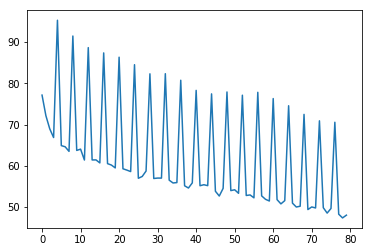

In [9]:
#LOSS PER ITERATIONS VISUALIZATION
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(lossgraph)

In [ ]:
## PREFORMANCE ASSESSMENT ON VALIDATION AND TRAIN DATA ##############################################
net.eval()

In [10]:
# ACCURACY TOTAL ON VALIDATION DATASET
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the validation(test) images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the validation(test) images: 60 %


In [11]:
# ACCURACY PER CLASS ON VALIDATION DATASET 
class_correct = list(0. for i in range(5)) # [0. for i in range(5)]  [0.]*5
class_total = list(0. for i in range(5))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10): # range(len(c))
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(5):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 62 %
Accuracy of     1 : 32 %
Accuracy of     2 : 45 %
Accuracy of     3 : 30 %
Accuracy of     4 : 40 %


In [12]:
# ACCURACY ON THE TRAIN DATA (FOR OVERFITTING OBSERVATIONS)
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy on the train images: %d %%' % (
    100 * correct / total))

Accuracy on the train images: 50 %


In [ ]:
#### FINAL SUBMISSION ON KAGGLE, PREFORMANCE ASSESSMENT ON TEST DATASET ###################################

In [ ]:
## USING TEST IMAGES  AND  RECORDING MODEL OUTPUT MAPPING 
import re
import pandas as pd
net.cpu()
net.eval()
test_data_dir = f'test/0/'
test_data_files = os.listdir(test_data_dir)


def extract_file_id(fname):
    return re.search('^.*(?=(\.jpeg))', fname).group()

def predict(net, image):
    batch = torch.stack([image])
    output=net(batch)
    _,preds=torch.max(output,1)
    return preds.item()


def test_data_from_fname(fname):
    test_data_dir = f'test/0/'
    image = Image.open(f'{test_data_dir}/{fname}')
    return val_trans(image)


EyeIDnPred = {extract_file_id(fname): 
                  predict(net,
test_data_from_fname(fname))
                  for fname in test_data_files}

In [13]:
###SAVE THE RESULTS OF TEST DATA PREFORMANCE TO CSV

ds = pd.Series({id : label for (id, label) in zip(EyeIDnPred.keys(), EyeIDnPred.values())})
ds.head()
df = pd.DataFrame(ds, columns = ['label']).sort_index()
df['id'] = df.index
df = df[['id', 'label']]
#df[["id","label"]]=["image","level"]
df.to_csv("submission.csv", index = False)

In [ ]:
#save the trained model
torch.save(net.state_dict(), "name_of_my_model.pth")

In [ ]:
#load model
net.load_state_dict(torch.load("name_of_my_model.pth"))

In [ ]:
##################################################################################################################################